<a href="https://colab.research.google.com/github/daffamaul30/K-Means/blob/master/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

## Mengambil data di drive
bisa dirubah dengan tidak menggunakan drive

In [0]:
from google.colab import drive #mount drive
drive.mount('/content/gdrive')
path = 'gdrive/My Drive/Colab Notebooks/Dataset.csv'
dataset = pd.read_csv(path)

In [66]:
dataset = dataset[['age','overall']]
dataset = pd.DataFrame(dataset, columns=['age', 'overall', 'cluster'])

#membuat kolom cluster yang diisi dengan -1
temp = []
for i in range(len(dataset['age'])):
    temp.append(-1)
    
dataset['cluster'] = temp

18278


In [67]:
dataset.head()

,age,overall,cluster
0,32,94,-1
1,34,93,-1
2,27,92,-1
3,26,91,-1
4,28,91,-1


In [68]:
dataset.shape

(18278, 3)

In [69]:
dataset.describe()

,age,overall,cluster
count,18278.000000,18278.000000,18278.0
mean,25.283291,66.244994,-1.0
std,4.656964,6.949953,0.0
min,16.000000,48.000000,-1.0
25%,22.000000,62.000000,-1.0
50%,25.000000,66.000000,-1.0
75%,29.000000,71.000000,-1.0
max,42.000000,94.000000,-1.0


In [70]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18278 entries, 0 to 18277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   age      18278 non-null  int64
 1   overall  18278 non-null  int64
 2   cluster  18278 non-null  int64
dtypes: int64(3)
memory usage: 428.5 KB


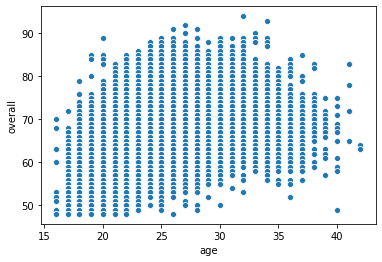

In [71]:
sns.scatterplot(x='age', y='overall', data=dataset)

## Pembuatan centroid dengan K = 3

In [72]:
centro = [
    [0, 0, '0'],
    [0, 0, '1'],
    [0, 0, '2'],
]
# kita buat menjadi dataframe
centroid = pd.DataFrame(centro, columns=['age', 'overall', 'cluster'])

age = []
overall = []
x0 = np.random.randint(min(dataset['age']),max(dataset['age']))
y0 = np.random.randint(min(dataset['overall']),max(dataset['overall']))
x1 = np.random.randint(min(dataset['age']),max(dataset['age']))
y1 = np.random.randint(min(dataset['overall']),max(dataset['overall']))
x2 = np.random.randint(min(dataset['age']),max(dataset['age']))
y2 = np.random.randint(min(dataset['overall']),max(dataset['overall']))

age.append(x0)
age.append(x1)
age.append(x2)
overall.append(y0)
overall.append(y1)
overall.append(y2)

centroid['age'] = age
centroid['overall'] = overall
centroid

,age,overall,cluster
0,33,63,0
1,29,59,1
2,27,51,2


penentuan centroid awal mempengaruhi hasil akhir clustering

## Memasukkan centroid sesuai titiknya

   age  overall cluster
0   33       63       0
1   29       59       1
2   27       51       2


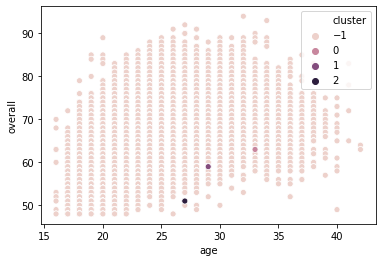

In [73]:
sns.scatterplot(x='age', y='overall', hue='cluster', data=dataset.append(centroid))
print(centroid)

cluster -1 artinya adalah belum masuk ke dalam salah satu cluster (bisa diganti angka lain)

## Pembuatan data untuk pergantian centroid

In [74]:
update = [
    [0, 0, '0'],
    [0, 0, '1'],
    [0, 0, '2'],
]

# kita buat menjadi dataframe
centroidBaru = pd.DataFrame(update, columns=['age', 'overall', 'cluster'])
centroidBaru

,age,overall,cluster
0,0,0,0
1,0,0,1
2,0,0,2


## Proses clustering dan perubahan titik centroid
dilakukan hingga posisi titik centroid sudah tidak berpindah lagi

In [0]:
notSame = True
j = 1
while (notSame is True): #akan melakukan looping selama "notSame " bernilai True (titik centroid sudah tidak berubah)
    clusterr = []
    baru  = []

    x02, y02 = centroid.iloc[0][['age', 'overall']] #mengambil titik Centroid ke 0
    x12, y12 = centroid.iloc[1][['age', 'overall']] #mengambil titik Centroid ke 1
    x22, y22 = centroid.iloc[2][['age', 'overall']] #mengambil titik Centroid ke 2

    #mencari centroid terdekat dengan setiap titik
    for i in range(len(dataset)):
        x1, y1 = dataset.iloc[i][['age', 'overall']] #mengambil titik untuk setiap data pada dataset

        # euclidean distance
        dist0 = ((x02-x1)**2 + (y02-y1)**2)**0.5 
        dist1 = ((x12-x1)**2 + (y12-y1)**2)**0.5
        dist2 = ((x22-x1)**2 + (y22-y1)**2)**0.5

        if (dist0 < dist1) and (dist0 < dist2):
            hasil = '0'
        elif  (dist1 < dist0) and (dist1 < dist2):
            hasil = '1'
        elif  (dist2 < dist0) and (dist2 < dist1):
            hasil = '2'
        clusterr.append(hasil)
    
    #ganti kolom 'cluster' pada dataset dengan list clusterr tadi
    dataset['cluster'] = clusterr 
    
    #Update centroid
    x0 = dataset[dataset['cluster'] == '0']['age'].tolist()
    y0 = dataset[dataset['cluster'] == '0']['overall'].tolist()
    
    #menghitung mean untuk nilai baru dari centroid 0
    mean_x0 = sum(x0) / len(x0) 
    mean_y0 = sum(y0) / len(y0)

    x1 = dataset[dataset['cluster'] == '1']['age'].tolist()
    y1 = dataset[dataset['cluster'] == '1']['overall'].tolist()
    
    #menghitung mean untuk nilai baru dari centroid 1
    mean_x1 = sum(x1) / len(x1)
    mean_y1 = sum(y1) / len(y1)

    x2 = dataset[dataset['cluster'] == '2']['age'].tolist()
    y2 = dataset[dataset['cluster'] == '2']['overall'].tolist()
    
    #menghitung mean untuk nilai baru dari centroid 2
    mean_x2 = sum(x2) / len(x2)
    mean_y2 = sum(y2) / len(y2)

    #mengganti nilai centroidBaru dengan mean yang sudah dihitung tadi
    centroidBaru.iloc[0,0] = mean_x0
    centroidBaru.iloc[0,1] = mean_y0
    centroidBaru.iloc[1,0] = mean_x1
    centroidBaru.iloc[1,1] = mean_y1
    centroidBaru.iloc[2,0] = mean_x2
    centroidBaru.iloc[2,1] = mean_y2

    if (centroidBaru.iloc[0,:2].all() != centroid.iloc[0,:2].all()):
        centroid,centroidBaru = centroidBaru, centroid 
    else:
        notSame = False
    # print('ini loop ke ', j)
    # j = j+1

In [76]:
centroidBaru

,age,overall,cluster
0,27.941849,74.763110,0
1,26.453290,66.066405,1
2,20.687173,58.153599,2


titik centroidnya sekarang seperti ini

## Hasil Clustering

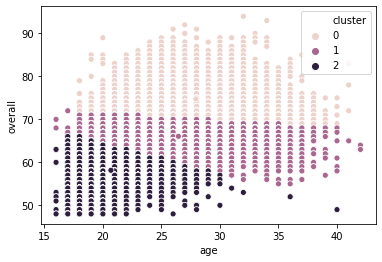

In [77]:
sns.scatterplot(x='age', y='overall', hue='cluster', data=dataset.append(centroid))